# The Capacitated Vehicle Routing Problem

A short example of using **Iterated Local Search** to model and solve the CRVP

> Vehicle routing problems are inherently intractable: the length of time it takes to solve them grows exponentially with the size of the problem. For sufficiently large problems, it could take routing software years to find the optimal solution... 

In [1]:
import numpy as np
from numpy.random import RandomState
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from metapy.tsp.euclidean import gen_matrix, euclidean_distance
from metapy.local_search.two_opt import OrdinaryDecentTwoOpt
from metapy.local_search.random_restarts import (IteratedLocalSearch, 
                                                 EpsilonGreedyHomeBase)
from metapy.tsp.objective import CVRPUnitDemandObjective


from metapy.tsp.init_solutions import VRPPopulationGenerator, TSPPopulationGenerator

from metapy.evolutionary.evolutionary import EvolutionaryAlgorithm
from metapy.evolutionary.strategy import ElitistGeneticAlgorithmStrategy
from metapy.evolutionary.selection import TournamentSelector
from metapy.evolutionary.mutation import TwoOptMutator
from metapy.evolutionary.crossover import PartiallyMappedCrossover

## Parameters

In [21]:
N_PATIENTS = 60
SEED = 101

## Patient Geographic Location

In [22]:
#random number generator for synthetic data.
rand_gen = RandomState(seed=SEED)

#n_patients = 1 so we include the depot
x_coords = rand_gen.random(size=N_PATIENTS+1) * 200
y_coords = rand_gen.random(size=N_PATIENTS+1) * 100

coords = [[x, y] for x, y in zip(x_coords, y_coords)]

In [23]:
def plot_patient_coordinates(x_coords, y_coords):
    '''
    Plot a simple scatter of coordinates. 
    Depot is red, customers are blue
    
    Paramters:
    x_coords: array-like
        x coordinates for each patient. element 0 = depot.
        
    y_coords: array-like
        y coordinates for each patient. element 0 = depot
    '''
    plt.plot(x_coords[0], y_coords[0], c='r', marker='^')
    
    for i in range(1, len(x_coords[1:])):
        x = x_coords[i]
        y = y_coords[i]
        plt.plot(x, y, 'b*')
        plt.text(x * (1 + 0.01), y * (1 + 0.01) , i, fontsize=12)
    
    plt.xlim((0, 220))
    plt.ylim((0, 120))
    plt.show()

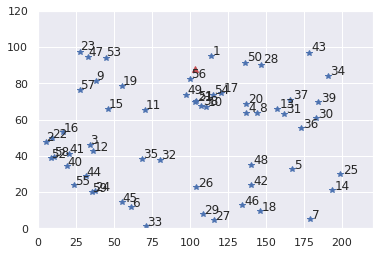

In [24]:
#visualise
plot_patient_coordinates(x_coords, y_coords)

## Approaches to 'solving' the CVRP

* Formulation as a Mixed Integer Programme (MIP) and use of a optimisation solver
* **Heuristic solution**.  E.g. using Iterated Local Search.

## Solution using Iterated Local Search

In [25]:
def create_solver(matrix, capacity, init_solution, random_state=None):
    cvrp_obj = CVRPUnitDemandObjective(matrix, 0, capacity)
    local_search = OrdinaryDecentTwoOpt(cvrp_obj, init_solution)
    ils = IteratedLocalSearch(cvrp_obj, 
                              local_search, 
                              accept=EpsilonGreedyHomeBase(), 
                              maximisation=False,
                              random_state=random_state)
    return ils

In [72]:
%%time 
init_solution = np.arange(N_PATIENTS+1)
distance_matrix = gen_matrix(np.array(coords))
ils_solver = create_solver(distance_matrix, 4, init_solution, random_state=28)
ils_solver.run(n=20)

CPU times: user 24.3 s, sys: 11.8 ms, total: 24.3 s
Wall time: 24.3 s


In [73]:
solution = ils_solver.get_best_solutions()[1][0]

In [74]:
ils_solver.get_best_solutions()[0]

#60 patients 
#ILS => 2551 in 36 seconds 
# remember its stochastic: rs=19 2551; rs=41 2561; rs=28 2509); avg = 2540
#gurobi (with 16 cores) => 2548 in 1233 seconds (optimality gap = 64%)

2509.1595628179944

In [60]:
np.savetxt('ils_best_60_solution_20reps_rs28.csv', solution, delimiter=',')

In [68]:
def convert_tour_to_routes(tour, capacity):
    '''
    Easy as demand comes in single units and
    capacity is an integer
    '''
    n_cities = len(tour)
    capacity = int(capacity)
    splits = [i for i in range(capacity, n_cities, capacity)]
    routes = np.split(tour, splits)
    return routes

In [69]:
routes = convert_tour_to_routes(solution[1:], 4)
routes

[array([48, 42, 18, 46]),
 array([27, 29, 26, 32]),
 array([ 1, 50, 28, 17]),
 array([19, 15,  3, 12]),
 array([24, 59, 55, 44]),
 array([54,  4,  8, 20]),
 array([25, 14,  7,  5]),
 array([57,  2, 22, 16]),
 array([40, 52, 58, 41]),
 array([35, 45,  6, 33]),
 array([11, 60, 49, 56]),
 array([13, 39, 34, 43]),
 array([37, 30, 36, 31]),
 array([10, 38, 21, 51]),
 array([ 9, 23, 47, 53])]

In [70]:
def plot_solution(routes, x_coords, y_coords):
    
    xc = x_coords
    yc = y_coords
    
    for route in routes:
        
        for k in range(len(route)-1):
            i, j = route[k], route[k+1]
            plt.plot([xc[i], xc[j]], [yc[i], yc[j]], c='green')
            
        plt.plot([xc[route[-1]], xc[0]], [yc[route[-1]], yc[0]], c='green')
        plt.plot([xc[route[0]], xc[0]], [yc[route[0]], yc[0]], c='green')
    
    plt.plot(xc[0], yc[0], c='r', marker='^')
    plt.scatter(xc[1:], yc[1:], c='b')
    
    i = 1
    for x, y in zip(x_coords[1:], y_coords[1:]):
        #plt.text(x * (1 + 0.01), y * (1 + 0.01) , i, fontsize=12)
        i += 1
        

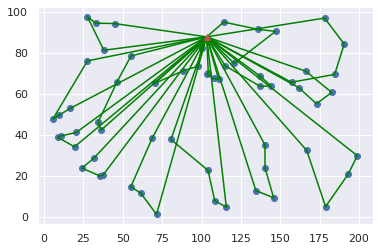

In [71]:
plot_solution(routes, x_coords, y_coords)

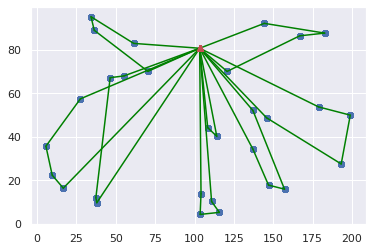

In [16]:
import pandas as pd
active_arcs = pd.read_csv('best_solution_30_patients.csv').to_numpy()

xc = x_coords
yc = y_coords

for i, j in active_arcs:
    plt.plot([xc[i], xc[j]], [yc[i], yc[j]], c='green')
    plt.plot(xc[0], yc[0], c='r', marker='^')
    plt.scatter(xc[1:], yc[1:], c='b')

## Solution by an Evolutionary Algorithm: Elitist Genetic Algorithm Strategy

In [75]:
#Evolutionary Algorithm - Genetic Algorithm strategy

def create_ga_solver(matrix, capacity, init_solution):

    _lambda = 500
    mew = 60
    cvrp_obj = CVRPUnitDemandObjective(matrix, 0, capacity)

    init = VRPPopulationGenerator(init_solution)
    strategy = ElitistGeneticAlgorithmStrategy(mew, 
                                               _lambda, 
                                               selector=TournamentSelector(),
                                               xoperator=PartiallyMappedCrossover(),
                                               mutator=TwoOptMutator())

    solver = EvolutionaryAlgorithm(init, cvrp_obj,_lambda, strategy, 
                                   maximisation=False, generations=500)
    return solver

In [76]:
init_solution

array([ 0, 45,  6, 33, 32, 34, 43, 28, 50,  4, 48,  8, 20,  9, 57, 23, 47,
       44, 12,  3, 15,  5, 36, 31, 13,  2, 52, 58, 41, 46, 27, 29, 26, 25,
       30, 39, 37,  1, 51, 21, 49, 55, 40, 22, 16, 38, 10, 54, 17, 14,  7,
       18, 42, 56, 11, 19, 53, 35, 24, 59, 60])

In [77]:
init_solution = np.arange(N_PATIENTS+1)
distance_matrix = gen_matrix(np.array(coords))
solver = create_ga_solver(distance_matrix, 4, init_solution)

In [78]:
solver.solve()

In [79]:
solver.best_fitness

2805.3576246470416

In [80]:
solution2 = solver.best_solution

In [84]:
routes2 = convert_tour_to_routes(solution2[1:], 4)
routes2

[array([25, 37, 36, 31], dtype=int8),
 array([21, 23, 47, 53], dtype=int8),
 array([19, 52, 58, 40], dtype=int8),
 array([55,  7, 18, 46], dtype=int8),
 array([29, 32,  6, 35], dtype=int8),
 array([60, 16, 22,  2], dtype=int8),
 array([57, 12, 41,  3], dtype=int8),
 array([ 9, 45, 24, 59], dtype=int8),
 array([44, 39, 34, 43], dtype=int8),
 array([ 1, 10, 49, 11], dtype=int8),
 array([15, 17,  4,  8], dtype=int8),
 array([20, 54, 38, 56], dtype=int8),
 array([ 0, 42,  5, 14], dtype=int8),
 array([30, 50, 28, 13], dtype=int8),
 array([51, 26, 27, 33], dtype=int8),
 array([48], dtype=int8)]

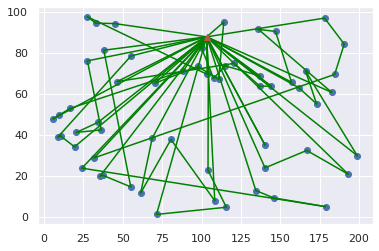

In [85]:
plot_solution(routes2, x_coords, y_coords)

In [83]:
solution2

array([25, 37, 36, 31, 21, 23, 47, 53, 19, 52, 58, 40, 55,  7, 18, 46, 29,
       32,  6, 35, 60, 16, 22,  2, 57, 12, 41,  3,  9, 45, 24, 59, 44, 39,
       34, 43,  1, 10, 49, 11, 15, 17,  4,  8, 20, 54, 38, 56,  0, 42,  5,
       14, 30, 50, 28, 13, 51, 26, 27, 33, 48], dtype=int8)